In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import os
import json
import cv2
import numpy as np
from PIL import Image 
from torchvision import models
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import KFold
import numpy as np
import re
import json
base_path = "./Data_122824/"
tr_folder_path = os.path.join(base_path, "Glioma_MDC_2025_training_normalized")
te_folder_path = os.path.join(base_path, "Glioma_MDC_2025_test_normalized")

In [2]:
torch.manual_seed(42)
np.random.seed(42)

In [3]:
# Function to check image sizes
def check_image_sizes(folder_path):
    sizes = {}
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".jpg"):
            file_path = os.path.join(folder_path, file_name)
            with Image.open(file_path) as img:
                size = img.size  # (width, height)
                sizes[file_name] = size
    return sizes

# Check image sizes in each folder
training_image_sizes = check_image_sizes(tr_folder_path)
testing_image_sizes = check_image_sizes(te_folder_path)

training_image_sizes_summary = {size: list(training_image_sizes.values()).count(size) for size in set(training_image_sizes.values())}
testing_image_sizes_summary = {size: list(testing_image_sizes.values()).count(size) for size in set(testing_image_sizes.values())}

training_image_sizes_summary, testing_image_sizes_summary

# All images are of 512 by 512 and need to be resized to 1015x1015 to fit JSON format

({(512, 512): 1439}, {(512, 512): 200})

In [4]:
def overlay_points_and_bboxes_with_crops(image, rois):
    """
    Overlay points and bounding boxes and return crops.
    """
    overlay_image = image.copy()
    crops = [] 
    for points in rois:
        points = np.array(points, dtype=np.int32)
        cv2.polylines(overlay_image, [points], isClosed=True, color=(255, 0, 0), thickness=2)

        x_min, y_min = np.min(points, axis=0)
        x_max, y_max = np.max(points, axis=0)
        cv2.rectangle(overlay_image, (x_min, y_min), (x_max, y_max), color=(0, 0, 255), thickness=2)

        crop = image[y_min:y_max, x_min:x_max]
        crops.append(crop)

    return overlay_image, crops

In [5]:
# Function to rescale coordinates if needed
def rescale_coordinates(points, original_size, target_size):
    """
    Rescale the points from the original size to the target size.
    """
    if original_size != target_size:
        scale_factor = target_size / original_size
        return [(int(x * scale_factor), int(y * scale_factor)) for x, y in points]
    else:
        return [(int(x), int(y)) for x, y in points]

In [6]:
def crops_image(image_path, json_path):
    """
    Plot the original image, overlayed image with bounding boxes, and cropped regions.
    """
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

    with open(json_path, 'r') as f:
        data = json.load(f)

    # Determine if rescaling is needed
    json_image_height = data['imageHeight']
    json_image_width = data['imageWidth']
    actual_image_height, actual_image_width, _ = image.shape

    # Rescale coordinates if the JSON dimensions differ from the actual image dimensions
    shapes = data['shapes']
    rois = [
        rescale_coordinates(shape['points'], json_image_height, actual_image_height) 
        for shape in shapes
    ]

    # Overlay the ROIs and bounding boxes on the image, and get cropped regions
    overlay_image, crops = overlay_points_and_bboxes_with_crops(image, rois)
    return overlay_image, crops



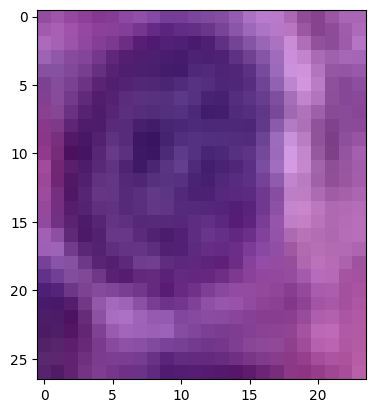

In [7]:
example_image_path = "./Data_122824/Glioma_MDC_2025_training_normalized/training0001.jpg"
example_json_path = "./Data_122824/Glioma_MDC_2025_training_normalized/training0001.json"


overlay_image,crops=crops_image(example_image_path ,example_json_path)

plt.imshow(crops[0])


In [8]:

training_files=os.listdir(tr_folder_path)
items = training_files
jpg_dict = {re.search(r'\d+', item).group(): item for item in items if item.endswith('.jpg')}
json_dict = {re.search(r'\d+', item).group(): item for item in items if item.endswith('.json')}

# Find matching numbers
matching_numbers = sorted(set(jpg_dict.keys()) & set(json_dict.keys()))

# Create parallel lists
jpg_files = [jpg_dict[num] for num in matching_numbers]
json_files = [json_dict[num] for num in matching_numbers]

all_image_patches=[]
all_labels=[]

for i in range(len(jpg_files)):
    jpg_file=jpg_files[i]
    json_file=json_files[i]
    jpg_file=tr_folder_path+'/'+jpg_file
    json_file=tr_folder_path+'/'+json_file

    overlay_image,crops=crops_image(jpg_file,json_file)
    labels=[]
    with open(json_file,'r', encoding='utf-8') as file:
        json_data = json.load(file)  # Load JSON content into a Python dictionary
        str_entries=json_data["shapes"]
        # print(str_entries)
        
        for entry in str_entries:
            label=entry["label"]
            labels.append(label)

    for j in range(len(crops)):
        crop=crops[j]
        label=labels[j]
        if crop.shape[0]>5:
            all_image_patches.append(crop)
            all_labels.append(label)
    # plt.imshow(overlay_image)
    # plt.show()

print(len(all_image_patches))
print(len(all_labels))

1614
1614


In [9]:
all_labels=[1 if label=='Mitosis' else 0 for label in all_labels]

In [10]:


# ========================
# Dataset Classes
# ========================

class PathologyDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        images: list of images (PIL Image or array)
        labels: list of ground truth labels (0 or 1)
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        # If image is not a PIL Image, convert it.
        if not isinstance(image, Image.Image):
            image = Image.fromarray(image)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Inference Dataset
class InferenceDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        image = self.images[idx]
        if not isinstance(image, Image.Image):
            image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        return image

# ========================
# Helper Functions
# ========================

def compute_metrics(outputs, labels):
    """
    Compute precision, recall, and F1 score from logits and true labels.
    """
    preds = (torch.sigmoid(outputs) > 0.5).float()
    labels = labels.float()
    
    TP = ((preds == 1) & (labels == 1)).sum().item()
    FP = ((preds == 1) & (labels == 0)).sum().item()
    FN = ((preds == 0) & (labels == 1)).sum().item()
    
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall    = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1        = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    
    return precision, recall, f1

def get_transforms():
    """Define common transforms for training and inference."""
    return transforms.Compose([
        transforms.Resize((224, 224)),  # ViT typically expects 224x224 images
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

def build_vit_model(for_final=False):
    """
    Instantiates a pretrained ViT model from torchvision, replaces the final 
    classification head with a binary classifier, and optionally freezes parameters.
    
    Args:
        for_final (bool): If True, freeze all parameters except for the final layer.
    Returns:
        model (nn.Module): The modified ViT model.
    """
    # Always start from the same pretrained weights.
    model = models.vit_b_16(weights="ViT_B_16_Weights.DEFAULT")
    num_features = model.heads.head.in_features  # For torchvision ViT, classifier is under heads.head
    model.heads.head = nn.Linear(num_features, 1)
    # # Replace classification head

    
    # model=models.swin_t(weights="Swin_T_Weights.DEFAULT")
    # num_features = model.head.in_features  # For Swin, the classifier is in 'head'
    # model.head = nn.Linear(num_features, 1)

    
    return model

def get_initial_state(for_final=False):
    """
    Returns the state dictionary of a freshly built model.
    This allows all training runs to start from the same initialization.
    """
    model = build_vit_model(for_final=for_final)
    return model.state_dict()

# ========================
# Training Functions
# ========================

def train_transfer_vit_cv(image_list, label_list, num_epochs=50, batch_size=32, learning_rate=1e-4):
    """
    Performs 10-fold cross validation on the provided dataset using a pretrained ViT.
    Returns a dictionary with average validation loss, precision, recall, and F1.
    """
    # Define transforms.
    transform = get_transforms()
    dataset = PathologyDataset(image_list, label_list, transform=transform)
    dataset_size = len(dataset)
    
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    
    # Get the common initial state for cross validation (for_final=False).
    initial_state = get_initial_state(for_final=False)
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_metrics = {
        "val_loss": [],
        "precision": [],
        "recall": [],
        "f1": []
    }
    
    fold_idx = 1
    for train_idx, val_idx in kf.split(np.arange(dataset_size)):
        print(f"\nStarting fold {fold_idx}...")
        train_subset = Subset(dataset, train_idx)
        val_subset   = Subset(dataset, val_idx)
        
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
        
        # Create a fresh model and load the same initial weights.
        model = build_vit_model(for_final=False)
        model.load_state_dict(initial_state)
        model = model.to(device)
        
        # Define loss and optimizer.
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        # Training loop for current fold.
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            for images, labels in train_loader:
                images = images.to(device)
                labels = labels.to(device).float().unsqueeze(1)
                
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * images.size(0)
            
            epoch_loss = running_loss / len(train_subset)
            print(f"Fold {fold_idx} | Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_loss:.4f}")
        
        # Validation phase for current fold.
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device).float().unsqueeze(1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                all_preds.append(outputs)
                all_labels.append(labels)
        
        val_loss /= len(val_subset)
        all_preds = torch.cat(all_preds, dim=0)
        all_labels = torch.cat(all_labels, dim=0)
        precision, recall, f1 = compute_metrics(all_preds, all_labels)
        
        print(f"Fold {fold_idx} | Val Loss: {val_loss:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
        fold_metrics["val_loss"].append(val_loss)
        fold_metrics["precision"].append(precision)
        fold_metrics["recall"].append(recall)
        fold_metrics["f1"].append(f1)
        
        fold_idx += 1
    
    # Compute average metrics over all folds.
    avg_val_loss = np.mean(fold_metrics["val_loss"])
    avg_precision = np.mean(fold_metrics["precision"])
    avg_recall = np.mean(fold_metrics["recall"])
    avg_f1 = np.mean(fold_metrics["f1"])
    
    print("\n10-Fold Cross Validation Results:")
    print(f"Average Validation Loss: {avg_val_loss:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    print(f"Average Recall: {avg_recall:.4f}")
    print(f"Average F1 Score: {avg_f1:.4f}")
    
    return {
        "avg_val_loss": avg_val_loss,
        "avg_precision": avg_precision,
        "avg_recall": avg_recall,
        "avg_f1": avg_f1
    }

def train_final_model(image_list, label_list, num_epochs=10, batch_size=32, learning_rate=1e-4):
    """
    Trains the model on the entire dataset and returns the final trained model using ViT.
    For the final training, the base layers are frozen except the final classification layer.
    """
    transform = get_transforms()
    dataset = PathologyDataset(image_list, label_list, transform=transform)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    
    # Get the common initial state for the final model (with final training settings).
    initial_state = get_initial_state(for_final=True)
    
    model = build_vit_model(for_final=True)
    model.load_state_dict(initial_state)
    model = model.to(device)
    
    # Define loss and optimizer.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
    
    # Training loop over the entire dataset.
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        
        epoch_loss = running_loss / len(dataset)
        print(f"Final Model Training | Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss:.4f}")
    
    return model

def train_and_get_model(image_list, label_list, num_epochs_cv=10, num_epochs_final=10, batch_size=32, learning_rate=1e-4):
    """
    Runs 5-fold cross validation to evaluate the ViT-based model, prints the averaged metrics,
    then retrains the model on the entire dataset and returns the final model.
    """
    print("Starting 5-fold cross validation...")
    cv_metrics = train_transfer_vit_cv(image_list, label_list,
                                       num_epochs=num_epochs_cv,
                                       batch_size=batch_size,
                                       learning_rate=learning_rate)
    
    print("\nRetraining final model on the entire dataset...")
    final_model = train_final_model(image_list, label_list,
                                    num_epochs=num_epochs_final,
                                    batch_size=batch_size,
                                    learning_rate=learning_rate)
    return final_model


In [11]:
trained_model = train_and_get_model(all_image_patches, all_labels, batch_size=16, learning_rate=1e-5)

Starting 5-fold cross validation...

Starting fold 1...


/home/zhixiu/anaconda3/envs/conch/lib/python3.10/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Fold 1 | Epoch 1/10 | Train Loss: 0.1661
Fold 1 | Epoch 2/10 | Train Loss: 0.0435
Fold 1 | Epoch 3/10 | Train Loss: 0.0342
Fold 1 | Epoch 4/10 | Train Loss: 0.0164
Fold 1 | Epoch 5/10 | Train Loss: 0.0081
Fold 1 | Epoch 6/10 | Train Loss: 0.0037
Fold 1 | Epoch 7/10 | Train Loss: 0.0019
Fold 1 | Epoch 8/10 | Train Loss: 0.0012
Fold 1 | Epoch 9/10 | Train Loss: 0.0008
Fold 1 | Epoch 10/10 | Train Loss: 0.0006
Fold 1 | Val Loss: 0.0850, Precision: 0.9945, Recall: 0.9731, F1: 0.9837

Starting fold 2...
Fold 2 | Epoch 1/10 | Train Loss: 0.1805
Fold 2 | Epoch 2/10 | Train Loss: 0.0452
Fold 2 | Epoch 3/10 | Train Loss: 0.0247
Fold 2 | Epoch 4/10 | Train Loss: 0.0161
Fold 2 | Epoch 5/10 | Train Loss: 0.0071
Fold 2 | Epoch 6/10 | Train Loss: 0.0028
Fold 2 | Epoch 7/10 | Train Loss: 0.0013
Fold 2 | Epoch 8/10 | Train Loss: 0.0008
Fold 2 | Epoch 9/10 | Train Loss: 0.0006
Fold 2 | Epoch 10/10 | Train Loss: 0.0005
Fold 2 | Val Loss: 0.1367, Precision: 0.9775, Recall: 0.9560, F1: 0.9667

Starting fo